# Îßµ ÏÉùÏÑ± Î∞è Í≤ÄÏ¶ù Îã®Í≥ÑÎ≥Ñ Î∂ÑÏÑù

## ÎùºÏù¥Î∏åÎü¨Î¶¨ Î∞è ÏÑ§Ï†ï

In [33]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import logging

from src.map_generator import MapGenerator
from src.spatial_analyzer import create_full_analysis, VisibilityAnalyzer
from src.validation_engine import ValidationEngine, create_default_rules
from src.logger import LoggerConfig

# Jupyter notebookÏóêÏÑú Í∑∏ÎûòÌîÑÎ•º inlineÏúºÎ°ú ÌëúÏãú
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

LoggerConfig.setup_logging(
    log_dir='../logs',
    log_level=logging.WARNING,
    console_output=False,
    file_output=True
)

# ÏãúÍ∞ÅÌôîÏãú ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÇ¨Ïö©
plt.rcParams['font.family'] = 'NanumSquare'
plt.rcParams['font.monospace'] = 'NanumSquare'
plt.rcParams['axes.unicode_minus'] = False

## ÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï

Îßµ ÏÉùÏÑ±/Î∂ÑÏÑùÏóê ÏÇ¨Ïö©Ìï† ÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï

**Ï§ëÏöî**: Ï†ÑÏàò Ï°∞ÏÇ¨Îäî Í≥ÑÏÇ∞ÎüâÏù¥ ÎßéÏúºÎØÄÎ°ú ÏûëÏùÄ Îßµ(64x64 ÎòêÎäî 128x128)ÏùÑ Í∂åÏû•
- 64x64: ~2.5Î∂Ñ
- 128x128: ~1-2ÏãúÍ∞Ñ  
- 256x256: ~23ÏãúÍ∞Ñ (ÎπÑÍ∂åÏû•)

In [34]:
# Îßµ ÏÉùÏÑ± ÌååÎùºÎØ∏ÌÑ∞
MAP_WIDTH = 64           # Îßµ ÎÑàÎπÑ (64x64 Í∂åÏû•, Ï†ÑÏàò Ï°∞ÏÇ¨Ïóê Ï†ÅÌï©)
MAP_HEIGHT = 64          # Îßµ ÎÜíÏù¥ (Îã®ÏúÑ: px)
OCTAVES = 6              # Perlin noise Ïò•ÌÉÄÎ∏å (ÎÜíÏùÑÏàòÎ°ù ÎîîÌÖåÏùº Ï¶ùÍ∞Ä)
PERSISTENCE = 0.5        # ÏûëÏùÄ ÎîîÌÖåÏùº Í∞ïÎèÑ
LACUNARITY = 2.0         # Ï£ºÌååÏàò Î∞∞Ïú®
SCALE = 100.0            # Ï†ÑÏ≤¥ Ïä§ÏºÄÏùº (ÏûëÏùÑÏàòÎ°ù Îπ†Î•∏ Î≥ÄÌôî)
SEED = 4                 # ÎûúÎç§ ÏãúÎìú (Í∞ôÏùÄ ÏãúÎìú = Í∞ôÏùÄ Îßµ)

# Î∂ÑÏÑù ÌååÎùºÎØ∏ÌÑ∞
OBSERVER_HEIGHT = 0.05   # Í¥ÄÏ∏°Ïûê ÎÜíÏù¥ (Ï∫êÎ¶≠ÌÑ∞ ÌÅ¨Í∏∞Î°ú ÏÑ§Ï†ï)
USE_FULL_ANALYSIS = True # True = Ï†ÑÏàò Ï°∞ÏÇ¨ (Î™®Îì† ÌîΩÏÖÄ), False = ÏÉòÌîåÎßÅ
NUM_SAMPLES = 50         # ÏÉòÌîåÎßÅ Î™®ÎìúÏö© ÏÉòÌîå Ïàò (Ï†ÑÏàò Ï°∞ÏÇ¨ Ïãú Î¨¥ÏãúÎê®)
EPSILON = 0.001          # ÎÜíÏù¥ ÎπÑÍµê ÌóàÏö© Ïò§Ï∞®

print("=" * 60)
print("ÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï")
print("=" * 60)
print(f"Îßµ ÌÅ¨Í∏∞: {MAP_WIDTH}x{MAP_HEIGHT}")
print(f"Perlin noise: octaves={OCTAVES}, persistence={PERSISTENCE}")
print(f"Î∂ÑÏÑù Î™®Îìú: {'FULL (Ï†ÑÏàò Ï°∞ÏÇ¨)' if USE_FULL_ANALYSIS else 'SAMPLING'}")
print(f"Í¥ÄÏ∏°Ïûê ÎÜíÏù¥: {OBSERVER_HEIGHT}")
print(f"ÏãúÎìú: {SEED}")
print("=" * 60)

if MAP_WIDTH > 128 and USE_FULL_ANALYSIS:
    print("Í≤ΩÍ≥†: ÌÅ∞ ÎßµÏóêÏÑú Ï†ÑÏàò Ï°∞ÏÇ¨Îäî Îß§Ïö∞ Ïò§Îûò Í±∏Î¶ΩÎãàÎã§!")

ÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
Îßµ ÌÅ¨Í∏∞: 64x64
Perlin noise: octaves=6, persistence=0.5
Î∂ÑÏÑù Î™®Îìú: FULL (Ï†ÑÏàò Ï°∞ÏÇ¨)
Í¥ÄÏ∏°Ïûê ÎÜíÏù¥: 0.05
ÏãúÎìú: 4


# 1. ÏõêÎ≥∏ Heightmap ÏÉùÏÑ±


**Perlin noise ÏïåÍ≥†Î¶¨Ï¶ò**ÏùÑ ÏÇ¨Ïö©, ÏûêÏó∞Ïä§Îü¨Ïö¥ ÏßÄÌòï ÏÉùÏÑ±


INFO     | Initialized MapGenerator: 64x64, octaves=6, seed=4
INFO     | Starting map generation...
INFO     | Map generation complete: 64x64, 2 zones


Îßµ ÏÉùÏÑ± Ï§ë
Îßµ ÏÉùÏÑ± ÏôÑÎ£å


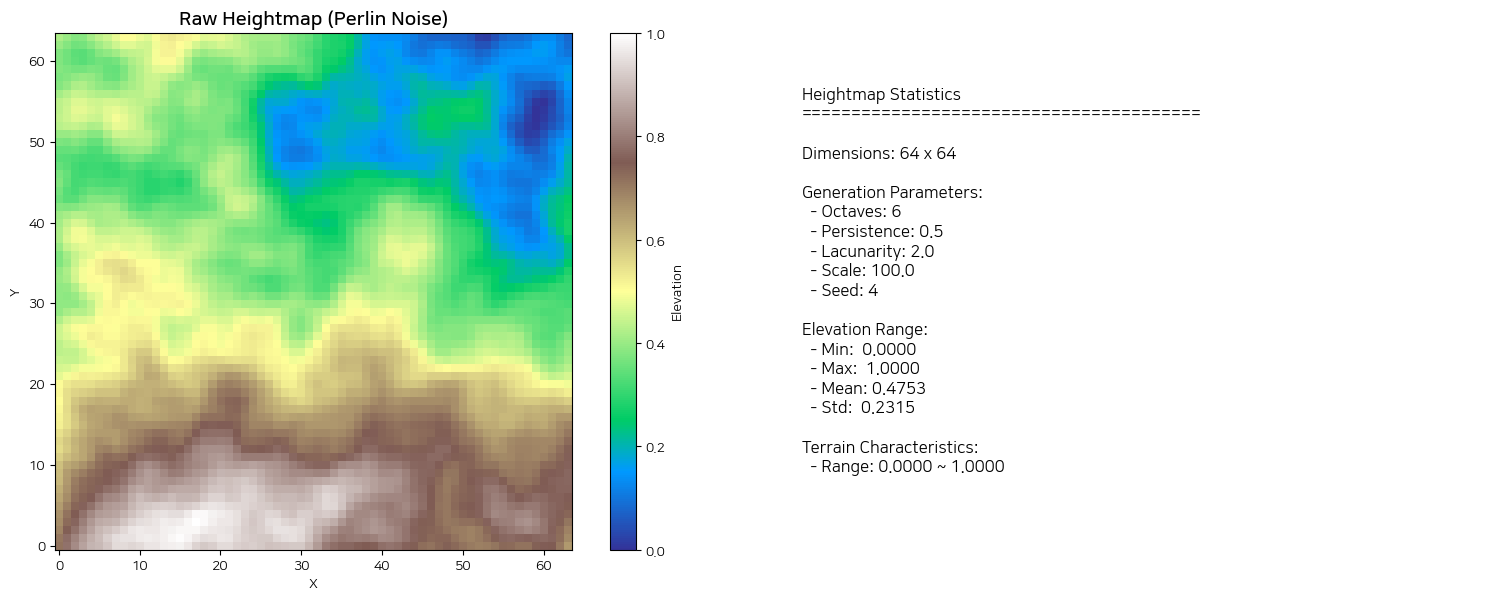

In [35]:
# Îßµ ÏÉùÏÑ±Í∏∞ Ï¥àÍ∏∞Ìôî
generator = MapGenerator(
    width=MAP_WIDTH,
    height=MAP_HEIGHT,
    octaves=OCTAVES,
    persistence=PERSISTENCE,
    lacunarity=LACUNARITY,
    scale=SCALE,
    seed=SEED
)

# Îßµ ÏÉùÏÑ±
print("Îßµ ÏÉùÏÑ± Ï§ë")
map_data = generator.generate_map()
# tqdm Îì±ÏúºÎ°ú ÏßÑÌñâÎ•† Í≥ÑÏÇ∞ÌïòÎ©¥ Ï¢ãÏùÑ Í≤É Í∞ôÏùå
print("Îßµ ÏÉùÏÑ± ÏôÑÎ£å")

# ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
heightmap = map_data.heightmap
stats = {
    'min': heightmap.min(),
    'max': heightmap.max(),
    'mean': heightmap.mean(),
    'std': heightmap.std()
}

# ÏãúÍ∞ÅÌôî
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Heightmap
im = ax1.imshow(heightmap, cmap='terrain', origin='lower')
ax1.set_title('Raw Heightmap (Perlin Noise)', fontsize=14, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
plt.colorbar(im, ax=ax1, label='Elevation')

# Heightmap Statistics
ax2.axis('off')
stats_text = f"""
Heightmap Statistics
{'='*40}

Dimensions: {MAP_WIDTH} x {MAP_HEIGHT}

Generation Parameters:
  - Octaves: {OCTAVES}
  - Persistence: {PERSISTENCE}
  - Lacunarity: {LACUNARITY}
  - Scale: {SCALE}
  - Seed: {SEED}

Elevation Range:
  - Min:  {stats['min']:.4f}
  - Max:  {stats['max']:.4f}
  - Mean: {stats['mean']:.4f}
  - Std:  {stats['std']:.4f}

Terrain Characteristics:
  - Range: {stats['min']:.4f} ~ {stats['max']:.4f}

"""
ax2.text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
         verticalalignment='center')

plt.tight_layout()
plt.show()

---

# 2. ÌåÄ Ï°¥ Ìï†Îãπ

ÎßµÏùÑ Team A (ÌååÎûÄÏÉâ)Í≥º Team B (Îπ®Í∞ÑÏÉâ) Íµ¨Ïó≠ÏúºÎ°ú Î∂ÑÌï†

- **Team Zone**: Í∞Å ÌåÄÏùò Ïä§Ìè∞ ÏßÄÏó≠ Î∞è Ï¥àÍ∏∞ Í±∞Ï†ê Îì±ÏùÑ ÏÑ§Î™ÖÌïòÍ∏∞ ÏúÑÌï®
- **Ï¢åÏö∞ ÎåÄÏπ≠**: ÏùºÎ∞òÏ†ÅÏúºÎ°ú Í≥µÏ†ïÏÑ±ÏùÑ ÏúÑÌï¥ Ï¢åÏö∞Î°ú Î∂ÑÌï†
- **Ï§ëÎ¶Ω ÏßÄÎåÄ**: Îëê ÌåÄ Ï°¥Ïù¥ ÏïÑÎãå Ï§ëÎ¶Ω ÏßÄÎåÄ

### ÌôïÏù∏ ÏÇ¨Ìï≠
- Îëê ÌåÄ Ï°¥Ïùò ÌÅ¨Í∏∞Í∞Ä ÎπÑÏä∑ÌïúÍ∞Ä?
- Í∞Å Ï°¥Ïóê ÎÜíÏùÄ/ÎÇÆÏùÄ ÏßÄÌòïÏù¥ Í≥†Î•¥Í≤å Î∂ÑÌè¨ÌïòÎäîÍ∞Ä?

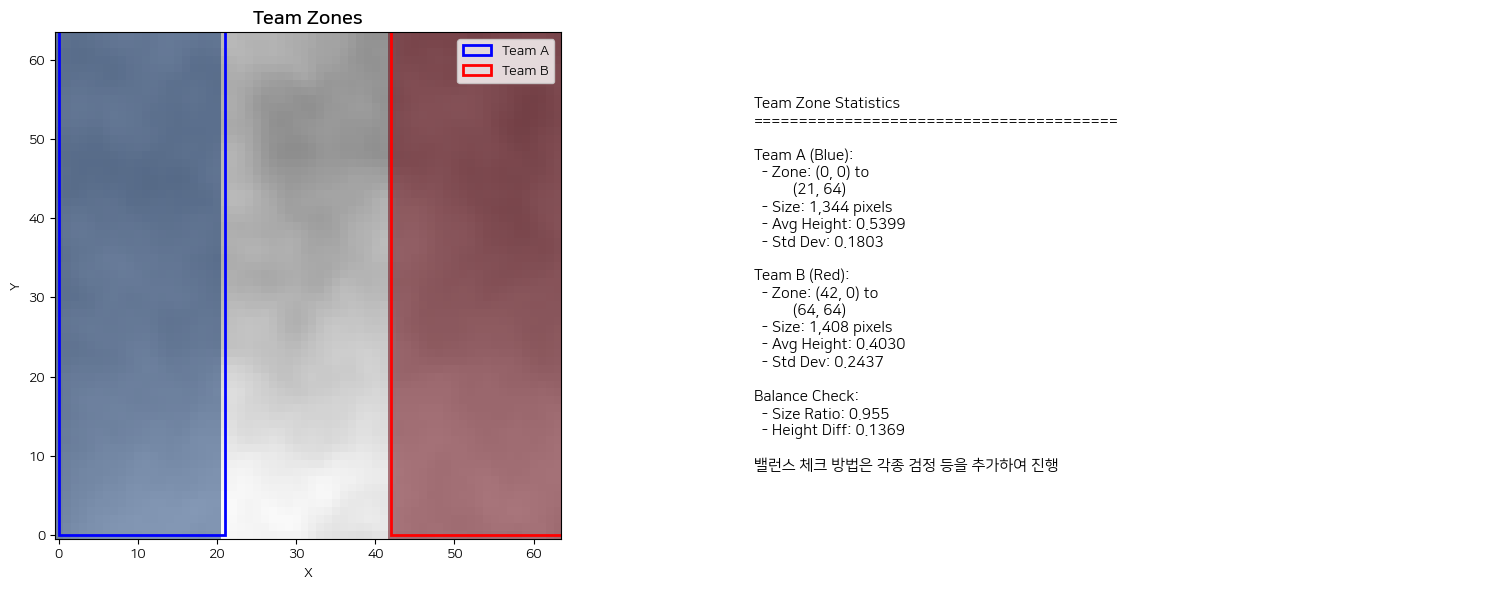

In [36]:
# ÌåÄ Ï°¥ Ï†ïÎ≥¥ Ï∂îÏ∂ú
zones = map_data.zones
team_a_zone = zones["team_a_zone"]
team_b_zone = zones["team_b_zone"]

# Ï°¥Î≥Ñ ÎßàÏä§ÌÅ¨ ÏÉùÏÑ±
mask_a = np.zeros_like(heightmap)
mask_b = np.zeros_like(heightmap)

for y in range(MAP_HEIGHT):
    for x in range(MAP_WIDTH):
        if team_a_zone.contains_point(x, y):
            mask_a[y, x] = 1
        elif team_b_zone.contains_point(x, y):
            mask_b[y, x] = 1

# Ï°¥Î≥Ñ ÌÜµÍ≥Ñ
zone_a_heights = heightmap[mask_a == 1]
zone_b_heights = heightmap[mask_b == 1]

zone_stats = {
    'team_a': {
        'size': len(zone_a_heights),
        'mean': zone_a_heights.mean(),
        'std': zone_a_heights.std()
    },
    'team_b': {
        'size': len(zone_b_heights),
        'mean': zone_b_heights.mean(),
        'std': zone_b_heights.std()
    }
}

# ÏãúÍ∞ÅÌôî
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Ï¢åÏ∏°: Ï°¥ Ïò§Î≤ÑÎ†àÏù¥
# HeightmapÏùÑ Í∏∞Î≥∏ÏúºÎ°ú ÌëúÏãú
ax1.imshow(heightmap, cmap='gray', alpha=0.5, origin='lower')
# Team A Ï°¥ (ÌååÎûÄÏÉâ)
ax1.imshow(np.ma.masked_where(mask_a == 0, mask_a), 
           cmap='Blues', alpha=0.5, origin='lower', vmin=0, vmax=1)
# Team B Ï°¥ (Îπ®Í∞ÑÏÉâ)
ax1.imshow(np.ma.masked_where(mask_b == 0, mask_b), 
           cmap='Reds', alpha=0.5, origin='lower', vmin=0, vmax=1)

ax1.set_title('Team Zones', fontsize=14, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

# Ï°¥ Í≤ΩÍ≥Ñ ÌëúÏãú
from matplotlib.patches import Rectangle
rect_a = Rectangle((team_a_zone.bounds[0], team_a_zone.bounds[2]),
                   team_a_zone.bounds[1] - team_a_zone.bounds[0],
                   team_a_zone.bounds[3] - team_a_zone.bounds[2],
                   fill=False, edgecolor='blue', linewidth=2, label='Team A')
rect_b = Rectangle((team_b_zone.bounds[0], team_b_zone.bounds[2]),
                   team_b_zone.bounds[1] - team_b_zone.bounds[0],
                   team_b_zone.bounds[3] - team_b_zone.bounds[2],
                   fill=False, edgecolor='red', linewidth=2, label='Team B')
ax1.add_patch(rect_a)
ax1.add_patch(rect_b)
ax1.legend(loc='upper right')

# Ïö∞Ï∏°: Ï°¥ ÌÜµÍ≥Ñ
ax2.axis('off')
stats_text = f"""
Team Zone Statistics
{'='*40}

Team A (Blue):
  - Zone: ({team_a_zone.bounds[0]}, {team_a_zone.bounds[2]}) to 
          ({team_a_zone.bounds[1]}, {team_a_zone.bounds[3]})
  - Size: {zone_stats['team_a']['size']:,} pixels
  - Avg Height: {zone_stats['team_a']['mean']:.4f}
  - Std Dev: {zone_stats['team_a']['std']:.4f}

Team B (Red):
  - Zone: ({team_b_zone.bounds[0]}, {team_b_zone.bounds[2]}) to 
          ({team_b_zone.bounds[1]}, {team_b_zone.bounds[3]})
  - Size: {zone_stats['team_b']['size']:,} pixels
  - Avg Height: {zone_stats['team_b']['mean']:.4f}
  - Std Dev: {zone_stats['team_b']['std']:.4f}

Balance Check:
  - Size Ratio: {zone_stats['team_a']['size'] / zone_stats['team_b']['size']:.3f}
  - Height Diff: {abs(zone_stats['team_a']['mean'] - zone_stats['team_b']['mean']):.4f}

Î∞∏Îü∞Ïä§ Ï≤¥ÌÅ¨ Î∞©Î≤ïÏùÄ Í∞ÅÏ¢Ö Í≤ÄÏ†ï Îì±ÏùÑ Ï∂îÍ∞ÄÌïòÏó¨ ÏßÑÌñâ
"""
ax2.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
         verticalalignment='center')

plt.tight_layout()
plt.show()

---

# 3. ÏÉòÌîå Ìè¨Ïù∏Ìä∏ Î∞∞Ïπò

Í∞ÄÏãúÏÑ± Î∂ÑÏÑùÏùÑ ÏúÑÌïú **ÎåÄÌëú ÏÉòÌîå Ìè¨Ïù∏Ìä∏**Î•º Í∞Å ÌåÄ Ï°¥Ïóê Í∑†Îì±ÌïòÍ≤å Î∞∞Ïπò

- **Observer Points (ÌååÎûÄÏÉâ)**: Team A Ï°¥Ïùò Í¥ÄÏ∏° ÏßÄÏ†ê
- **Target Points (Îπ®Í∞ÑÏÉâ)**: Team B Ï°¥Ïùò ÌÉÄÍ≤ü ÏßÄÏ†ê
- **ÏÉòÌîåÎßÅ Ï†ÑÎûµ**: Î™®Îì† Ï†êÏùÑ Ï≤¥ÌÅ¨Ìï† Ïàò ÏóÜÏúºÎØÄÎ°ú ÎåÄÌëú ÏÉòÌîå ÏÇ¨Ïö©

### ÏÉòÌîå ÏàòÏôÄ Ï†ïÌôïÎèÑ
- 50Í∞ú: ~95% Ïã†Î¢∞ÎèÑ
- 100Í∞ú: ~99% Ïã†Î¢∞ÎèÑ
- Îçî ÎßéÏùÑÏàòÎ°ù Ï†ïÌôïÌïòÏßÄÎßå Í≥ÑÏÇ∞ ÏãúÍ∞Ñ Ï¶ùÍ∞Ä

‚úì 50Í∞ú Í¥ÄÏ∏°Ï†ê ÏÉùÏÑ± (Team A)
‚úì 50Í∞ú ÌÉÄÍ≤üÏ†ê ÏÉùÏÑ± (Team B)


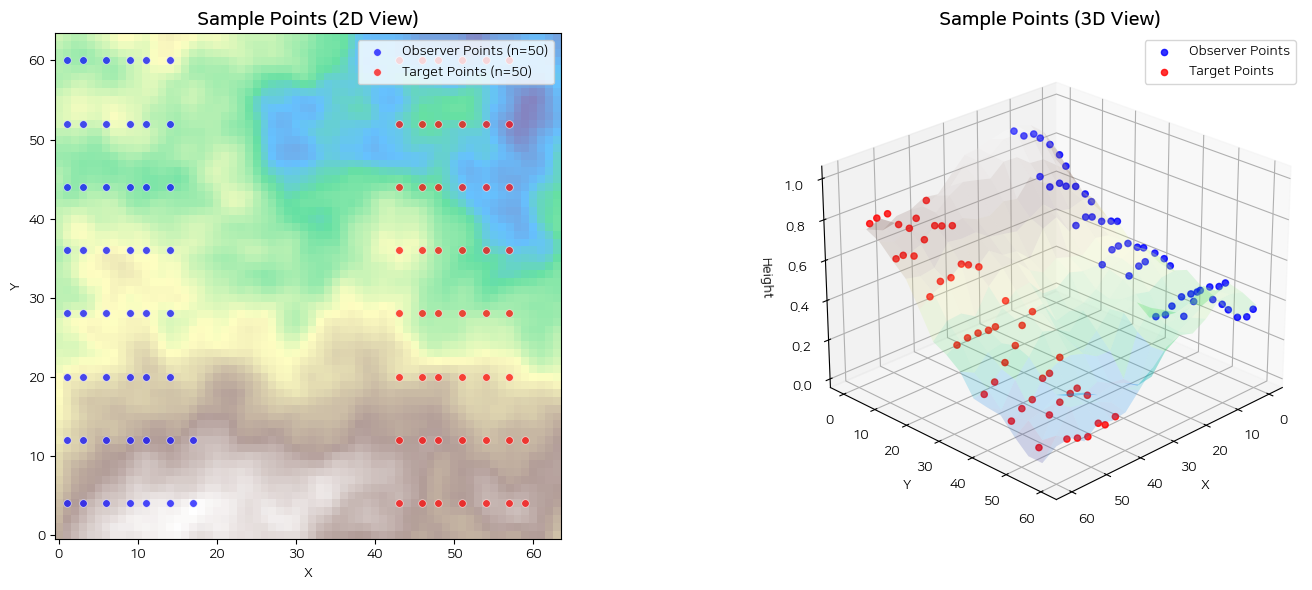

In [37]:
# ÏÉòÌîå Ìè¨Ïù∏Ìä∏ ÏÉùÏÑ±
def generate_sample_points(zone, heightmap, num_samples):
    """Ï°¥ ÎÇ¥ÏóêÏÑú Í∑†Îì±ÌïòÍ≤å ÏÉòÌîå Ìè¨Ïù∏Ìä∏ ÏÉùÏÑ±"""
    points = []
    x_range = zone.bounds[1] - zone.bounds[0]
    y_range = zone.bounds[3] - zone.bounds[2]
    
    grid_size = int(np.ceil(np.sqrt(num_samples)))
    x_step = x_range / grid_size
    y_step = y_range / grid_size
    
    for i in range(grid_size):
        for j in range(grid_size):
            if len(points) >= num_samples:
                break
            x = int(zone.bounds[0] + (i + 0.5) * x_step)
            y = int(zone.bounds[2] + (j + 0.5) * y_step)
            if zone.contains_point(x, y):
                h = heightmap[y, x]
                points.append((x, y, h))
    
    return np.array(points[:num_samples])

# Team A Í¥ÄÏ∏°Ï†ê, Team B ÌÉÄÍ≤üÏ†ê ÏÉùÏÑ±
observer_points = generate_sample_points(team_a_zone, heightmap, NUM_SAMPLES)
target_points = generate_sample_points(team_b_zone, heightmap, NUM_SAMPLES)

print(f"‚úì {len(observer_points)}Í∞ú Í¥ÄÏ∏°Ï†ê ÏÉùÏÑ± (Team A)")
print(f"‚úì {len(target_points)}Í∞ú ÌÉÄÍ≤üÏ†ê ÏÉùÏÑ± (Team B)")

# ÏãúÍ∞ÅÌôî
fig = plt.figure(figsize=(16, 6))

# Ï¢åÏ∏°: 2D Î∑∞
ax1 = fig.add_subplot(121)
ax1.imshow(heightmap, cmap='terrain', origin='lower', alpha=0.6)
ax1.scatter(observer_points[:, 0], observer_points[:, 1], 
           c='blue', s=30, alpha=0.7, label=f'Observer Points (n={len(observer_points)})', 
           edgecolors='white', linewidth=0.5)
ax1.scatter(target_points[:, 0], target_points[:, 1], 
           c='red', s=30, alpha=0.7, label=f'Target Points (n={len(target_points)})', 
           edgecolors='white', linewidth=0.5)
ax1.set_title('Sample Points (2D View)', fontsize=14, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.legend(loc = 1)

# Ïö∞Ï∏°: 3D Î∑∞
ax2 = fig.add_subplot(122, projection='3d')
x = np.arange(0, MAP_WIDTH, 4)
y = np.arange(0, MAP_HEIGHT, 4)
X, Y = np.meshgrid(x, y)
Z = heightmap[::4, ::4]
ax2.plot_surface(X, Y, Z, cmap='terrain', alpha=0.2, antialiased=True)
ax2.scatter(observer_points[:, 0], observer_points[:, 1], observer_points[:, 2],
           c='blue', s=20, alpha=0.8, label='Observer Points')
ax2.scatter(target_points[:, 0], target_points[:, 1], target_points[:, 2],
           c='red', s=20, alpha=0.8, label='Target Points')
ax2.set_title('Sample Points (3D View)', fontsize=14, fontweight='bold')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Height')
ax2.legend()
ax2.view_init(elev=25, azim=45)

plt.tight_layout()
plt.show()


---

# 4. ÏãúÏïºÏÑ†(Line-of-Sight) Îç∞Î™®

ÏßÄÌòï Ïû•Ïï†Î¨ºÏùÑ Í≥†Î†§Ìïú **Í∞ÄÏãúÏÑ± Î∂ÑÏÑù** ÏàòÌñâ

- **ÎÖπÏÉâ ÏÑ†**: ÏãúÏïºÍ∞Ä ÌôïÎ≥¥Îê® (Î≥¥ÏûÑ)
- **Îπ®Í∞ÑÏÉâ ÏÑ†**: ÏßÄÌòïÏóê Í∞ÄÎ†§Ïßê (Ïïà Î≥¥ÏûÑ)
- **ÏïåÍ≥†Î¶¨Ï¶ò**: Bresenham's line algorithm Í∏∞Î∞ò

### ÏûëÎèô ÏõêÎ¶¨
1. Í¥ÄÏ∏°Ï†êÏóêÏÑú ÌÉÄÍ≤üÏ†êÏúºÎ°ú ÏßÅÏÑ† Í∑∏Î¶¨Í∏∞
2. Í≤ΩÎ°úÏÉÅÏùò Î™®Îì† Ï†êÏóêÏÑú ÏßÄÌòï ÎÜíÏù¥ Ï≤¥ÌÅ¨
3. ÏßÄÌòïÏù¥ ÏãúÏïºÏÑ†Î≥¥Îã§ ÎÜíÏúºÎ©¥ ‚Üí Ï∞®Îã®
4. Î™®Îëê ÌÜµÍ≥ºÌïòÎ©¥ ‚Üí Í∞ÄÏãú Í∞ÄÎä•

20Í∞ú ÏãúÏïºÏÑ† Í≥ÑÏÇ∞ Ï§ë...
‚úì Í∞ÄÏãú: 55Í∞ú, Ï∞®Îã®: 345Í∞ú


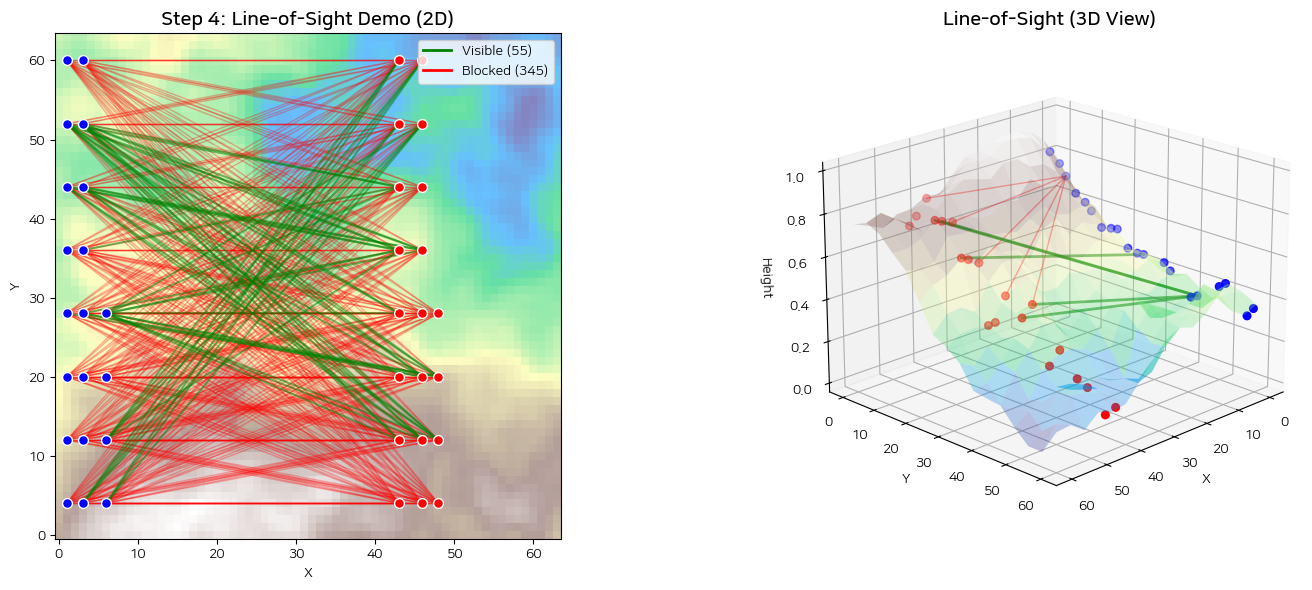

In [38]:
# Í∞ÄÏãúÏÑ± Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî
visibility_analyzer = VisibilityAnalyzer(observer_height=OBSERVER_HEIGHT, epsilon=EPSILON)

# Îç∞Î™®Ïö©ÏúºÎ°ú Î™á Í∞úÏùò ÏãúÏïºÏÑ†Îßå Ï≤¥ÌÅ¨
num_demo_lines = 20
demo_observers = observer_points[:num_demo_lines]
demo_targets = target_points[:num_demo_lines]

print(f"{num_demo_lines}Í∞ú ÏãúÏïºÏÑ† Í≥ÑÏÇ∞ Ï§ë...")

visible_lines = []
blocked_lines = []

for obs in demo_observers:
    for tgt in demo_targets:
        obs_point = (int(obs[0]), int(obs[1]))
        tgt_point = (int(tgt[0]), int(tgt[1]))
        
        if visibility_analyzer.check_line_of_sight(obs_point, tgt_point, heightmap):
            visible_lines.append((obs, tgt))
        else:
            blocked_lines.append((obs, tgt))

print(f"‚úì Í∞ÄÏãú: {len(visible_lines)}Í∞ú, Ï∞®Îã®: {len(blocked_lines)}Í∞ú")

# ÏãúÍ∞ÅÌôî
fig = plt.figure(figsize=(16, 6))

# Ï¢åÏ∏°: 2D Î∑∞
ax1 = fig.add_subplot(121)
ax1.imshow(heightmap, cmap='terrain', origin='lower', alpha=0.6)

# Ï∞®Îã®Îêú ÏÑ† (Îπ®Í∞ÑÏÉâ)
for obs, tgt in blocked_lines:
    ax1.plot([obs[0], tgt[0]], [obs[1], tgt[1]], 'r-', alpha=0.3, linewidth=1)

# Í∞ÄÏãú ÏÑ† (ÎÖπÏÉâ)
for obs, tgt in visible_lines:
    ax1.plot([obs[0], tgt[0]], [obs[1], tgt[1]], 'g-', alpha=0.5, linewidth=1.5)

ax1.scatter(demo_observers[:, 0], demo_observers[:, 1], 
           c='blue', s=50, zorder=5, edgecolors='white', linewidth=1)
ax1.scatter(demo_targets[:, 0], demo_targets[:, 1], 
           c='red', s=50, zorder=5, edgecolors='white', linewidth=1)

# Î≤îÎ°Ä
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='g', linewidth=2, label=f'Visible ({len(visible_lines)})'),
    Line2D([0], [0], color='r', linewidth=2, label=f'Blocked ({len(blocked_lines)})')
]
ax1.legend(handles=legend_elements, loc='upper right')

ax1.set_title('Step 4: Line-of-Sight Demo (2D)', fontsize=14, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

# Ïö∞Ï∏°: 3D Î∑∞
ax2 = fig.add_subplot(122, projection='3d')
x = np.arange(0, MAP_WIDTH, 4)
y = np.arange(0, MAP_HEIGHT, 4)
X, Y = np.meshgrid(x, y)
Z = heightmap[::4, ::4]
ax2.plot_surface(X, Y, Z, cmap='terrain', alpha=0.3, antialiased=True)

# Ï∞®Îã®Îêú ÏÑ†
for obs, tgt in blocked_lines[:5]:  # ÎÑàÎ¨¥ ÎßéÏúºÎ©¥ Î≥µÏû°ÌïòÎØÄÎ°ú ÏùºÎ∂ÄÎßå
    ax2.plot([obs[0], tgt[0]], [obs[1], tgt[1]], [obs[2], tgt[2]], 
            'r-', alpha=0.4, linewidth=1)

# Í∞ÄÏãú ÏÑ†
for obs, tgt in visible_lines[:5]:
    ax2.plot([obs[0], tgt[0]], [obs[1], tgt[1]], [obs[2], tgt[2]], 
            'g-', alpha=0.6, linewidth=2)

ax2.scatter(demo_observers[:, 0], demo_observers[:, 1], demo_observers[:, 2],
           c='blue', s=30, zorder=5)
ax2.scatter(demo_targets[:, 0], demo_targets[:, 1], demo_targets[:, 2],
           c='red', s=30, zorder=5)

ax2.set_title('Line-of-Sight (3D View)', fontsize=14, fontweight='bold')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Height')
ax2.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

visibility_rate = len(visible_lines) / (len(visible_lines) + len(blocked_lines))

---

# 5. ÎÖ∏Ï∂úÎèÑ(Exposure) Í≥ÑÏÇ∞

Í∞Å ÌåÄÏùò **Ï†ÑÏà†Ï†Å Ï∑®ÏïΩÏÑ±**ÏùÑ **ÌîΩÏÖÄ Îã®ÏúÑÎ°ú** Ï†ïÎüâÌôîÌï©ÎãàÎã§.

## Ï†ÑÏàò Ï°∞ÏÇ¨ (Exhaustive Analysis)

**Î™®Îì† ÌîΩÏÖÄ**Ïóê ÎåÄÌï¥ Ï†ïÌôïÌïú ÎÖ∏Ï∂úÎèÑÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§:
- Team A Ï°¥Ïùò Í∞Å ÌîΩÏÖÄÏù¥ Team BÏóêÍ≤å ÏñºÎßàÎÇò Î≥¥Ïù¥ÎäîÏßÄ
- Team B Ï°¥Ïùò Í∞Å ÌîΩÏÖÄÏù¥ Team AÏóêÍ≤å ÏñºÎßàÎÇò Î≥¥Ïù¥ÎäîÏßÄ

### Í≥ÑÏÇ∞ Î∞©Î≤ï
```
Í∞Å ÌÉÄÍ≤ü ÌîΩÏÖÄÏóê ÎåÄÌï¥:
  visible_count = 0
  for each observer_pixel:
    if can_see(observer_pixel, target_pixel):
      visible_count += 1
  
  exposure = visible_count / total_observers
```

### Exposure Ratio ÏùòÎØ∏
- **0.0** = Ï†ÑÌòÄ Ïïà Î≥¥ÏûÑ (ÏôÑÏ†Ñ ÏóÑÌèê, ÏïàÏ†ÑÌïú ÏúÑÏπò)
- **0.5** = Ï†àÎ∞ò Î≥¥ÏûÑ (Ï§ëÍ∞Ñ ÎÖ∏Ï∂ú)
- **1.0** = ÏôÑÏ†ÑÌûà Î≥¥ÏûÑ (ÏôÑÏ†Ñ ÎÖ∏Ï∂ú, ÏúÑÌóòÌïú ÏúÑÏπò)

### ÏàòÏπò Ìï¥ÏÑù (ÏòàÏãú)
- 0.0~0.2: ÎÇÆÏùÄ ÎÖ∏Ï∂ú (Î∞©Ïñ¥Ï†Å, ÏóÑÌèê ÏßÄÏó≠)
- 0.2~0.4: Ï†ÅÎãπÌïú ÎÖ∏Ï∂ú (Í∑†ÌòïÏû°Ìûå ÏßÄÏó≠)
- 0.4~0.6: ÎÜíÏùÄ ÎÖ∏Ï∂ú (Í≥µÍ≤©Ï†Å, Í∞úÎ∞© ÏßÄÏó≠)
- 0.6~1.0: Îß§Ïö∞ ÎÜíÏùÄ ÎÖ∏Ï∂ú (ÏúÑÌóò ÏßÄÏó≠)


In [39]:
import time

print("=" * 80)
print("ÌîΩÏÖÄÎ≥Ñ Ï†ÑÏàò Ï°∞ÏÇ¨ ÏãúÏûë")
print("=" * 80)

# Î∞©Î≤ï 1: create_full_analysis ÏÇ¨Ïö© (Í∂åÏû•)
if USE_FULL_ANALYSIS:
    print("üî¨ Î™®Îìú: FULL (Ï†ÑÏàò Ï°∞ÏÇ¨ - Î™®Îì† ÌîΩÏÖÄ Î∂ÑÏÑù)")
    print(f"‚è≥ ÏòàÏÉÅ ÏãúÍ∞Ñ: {MAP_WIDTH}x{MAP_HEIGHT} Îßµ = ÏïΩ 2-5Î∂Ñ")
    print()
    
    start_time = time.time()
    
    # Ï†ÑÏàò Ï°∞ÏÇ¨ Ïã§Ìñâ
    analysis_results = create_full_analysis(
        map_data,
        observer_height=OBSERVER_HEIGHT,
        use_full_analysis=True  # ‚Üê Ï†ÑÏàò Ï°∞ÏÇ¨ Î™®Îìú
    )
    
    elapsed = time.time() - start_time
    print(f"Î∂ÑÏÑù ÏôÑÎ£å (ÏÜåÏöî ÏãúÍ∞Ñ: {elapsed:.1f}Ï¥à = {elapsed/60:.2f}Î∂Ñ)")
    
else:
    print("Î™®Îìú: SAMPLING (ÏÉòÌîåÎßÅ - Îπ†Î•∏ Í∑ºÏÇ¨)")
    print(f"ÏÉòÌîå Ïàò: {NUM_SAMPLES}Í∞ú/Ï°¥")
    print()
    
    start_time = time.time()
    
    analysis_results = create_full_analysis(
        map_data,
        num_samples=NUM_SAMPLES,
        observer_height=OBSERVER_HEIGHT,
        use_full_analysis=False  # ÏÉòÌîåÎßÅ Î™®Îìú
    )
    
    elapsed = time.time() - start_time
    print(f"Î∂ÑÏÑù ÏôÑÎ£å! (ÏÜåÏöî ÏãúÍ∞Ñ: {elapsed:.1f}Ï¥à)")

print()


INFO     | Using FULL pixel-by-pixel analysis (exhaustive search)
INFO     | Starting FULL pixel-by-pixel visibility analysis
INFO     | Analyzing 2 zone pairs
INFO     | Calculating pixel-by-pixel exposure: team_a_zone -> team_b_zone
INFO     | Full analysis: 1,344 observers √ó 1,408 targets = 1,892,352 checks


ÌîΩÏÖÄÎ≥Ñ Ï†ÑÏàò Ï°∞ÏÇ¨ ÏãúÏûë
üî¨ Î™®Îìú: FULL (Ï†ÑÏàò Ï°∞ÏÇ¨ - Î™®Îì† ÌîΩÏÖÄ Î∂ÑÏÑù)
‚è≥ ÏòàÏÉÅ ÏãúÍ∞Ñ: 64x64 Îßµ = ÏïΩ 2-5Î∂Ñ



INFO     | Pixel exposure map complete: mean=0.242
INFO     | Calculating pixel-by-pixel exposure: team_b_zone -> team_a_zone
INFO     | Full analysis: 1,408 observers √ó 1,344 targets = 1,892,352 checks
INFO     | Pixel exposure map complete: mean=0.242
INFO     | Full analysis complete: Team A=0.242, Team B=0.242, Diff=0.000


Î∂ÑÏÑù ÏôÑÎ£å (ÏÜåÏöî ÏãúÍ∞Ñ: 207.2Ï¥à = 3.45Î∂Ñ)



ÎÖ∏Ï∂úÎèÑ Î∂ÑÏÑù Í≤∞Í≥º:
  Team A: 0.2418 (24.18%)
  Team B: 0.2421 (24.21%)
  ÌèâÍ∑†: 0.2420
  Ï∞®Ïù¥: 0.0002

ÌîΩÏÖÄÎ≥Ñ ÎÖ∏Ï∂úÎèÑ Îßµ ÏÉùÏÑ±Îê®
  Team A Îßµ ÌÅ¨Í∏∞: (64, 64)
  Team B Îßµ ÌÅ¨Í∏∞: (64, 64)

  Team A ÎÖ∏Ï∂úÎèÑ Î≤îÏúÑ: 0.000 ~ 0.801
  Team B ÎÖ∏Ï∂úÎèÑ Î≤îÏúÑ: 0.000 ~ 0.749

  Team A: ÏúÑÌóò ÏßÄÏó≠ 184px, ÏïàÏ†Ñ ÏßÄÏó≠ 945px
  Team B: ÏúÑÌóò ÏßÄÏó≠ 261px, ÏïàÏ†Ñ ÏßÄÏó≠ 902px



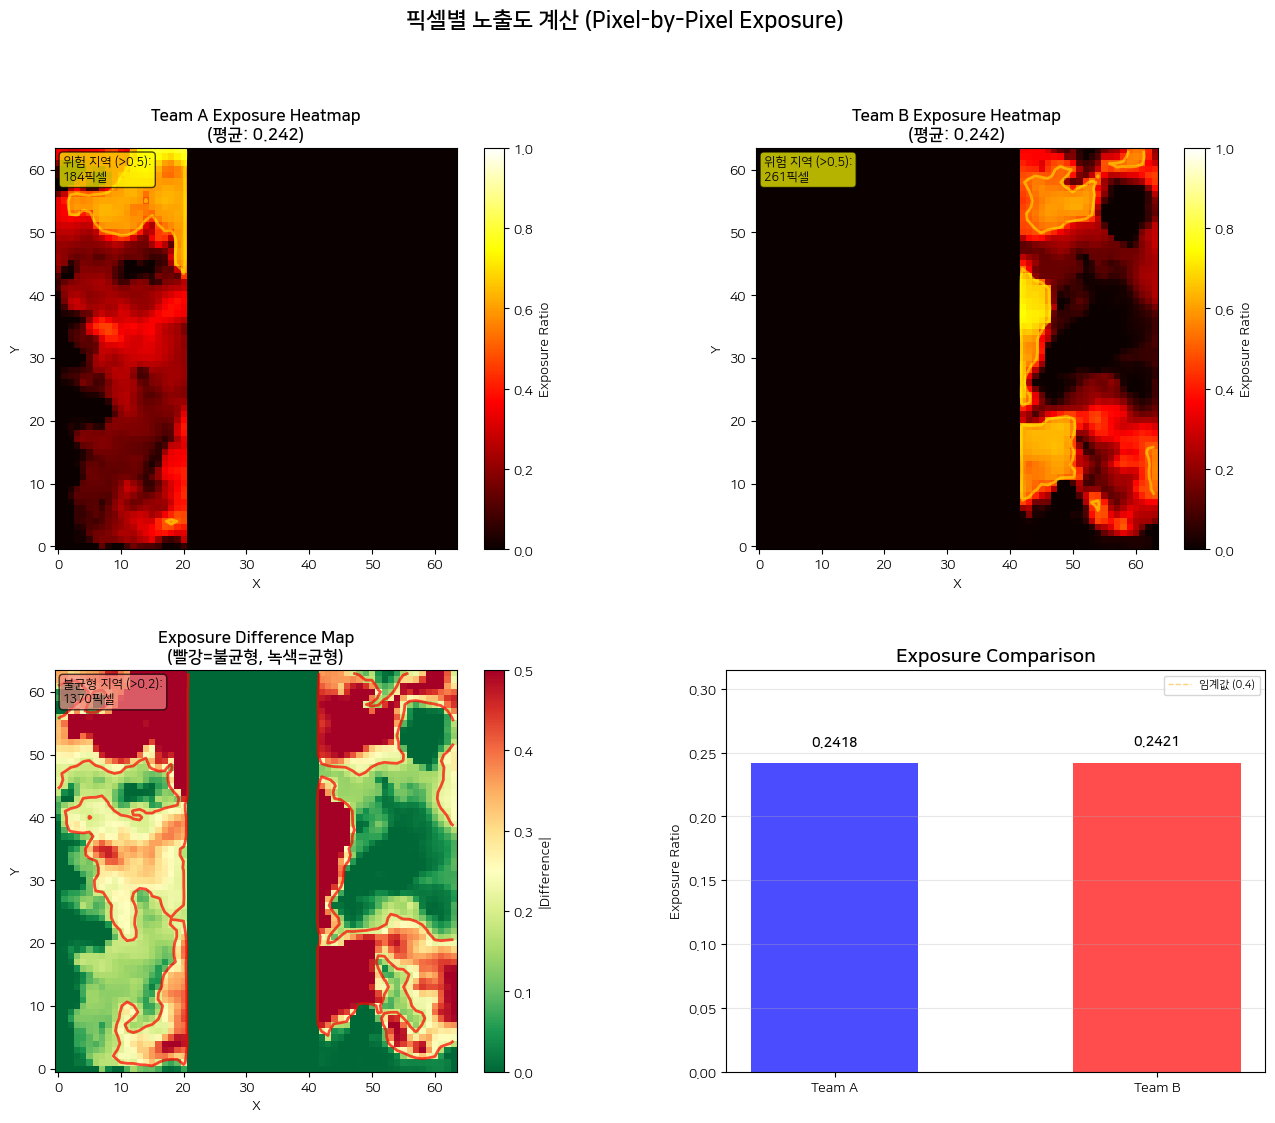


ÎÖ∏Ï∂úÎèÑ Ï∞®Ïù¥: 0.0002


In [108]:
# Í≤∞Í≥º Ï∂îÏ∂ú
metrics = analysis_results['visibility_metrics']
team_a_exposure = metrics['team_a_exposure']
team_b_exposure = metrics['team_b_exposure']
avg_exposure = metrics['avg_exposure']
exposure_diff = metrics['exposure_difference']

print("ÎÖ∏Ï∂úÎèÑ Î∂ÑÏÑù Í≤∞Í≥º:")
print(f"  Team A: {team_a_exposure:.4f} ({team_a_exposure*100:.2f}%)")
print(f"  Team B: {team_b_exposure:.4f} ({team_b_exposure*100:.2f}%)")
print(f"  ÌèâÍ∑†: {avg_exposure:.4f}")
print(f"  Ï∞®Ïù¥: {exposure_diff:.4f}")
print()

# ÌîΩÏÖÄÎ≥Ñ ÎÖ∏Ï∂úÎèÑ Îßµ Í∞ÄÏ†∏Ïò§Í∏∞
team_a_exposure_map = analysis_results.get('team_a_exposure_map')
team_b_exposure_map = analysis_results.get('team_b_exposure_map')

if team_a_exposure_map is not None:
    print("ÌîΩÏÖÄÎ≥Ñ ÎÖ∏Ï∂úÎèÑ Îßµ ÏÉùÏÑ±Îê®")
    print(f"  Team A Îßµ ÌÅ¨Í∏∞: {team_a_exposure_map.shape}")
    print(f"  Team B Îßµ ÌÅ¨Í∏∞: {team_b_exposure_map.shape}")
    
    # ÌîΩÏÖÄÎ≥Ñ ÌÜµÍ≥Ñ
    team_a_mask = map_data.get_zone_mask('team_a_zone')
    team_b_mask = map_data.get_zone_mask('team_b_zone')
    
    a_values = team_a_exposure_map[team_a_mask]
    b_values = team_b_exposure_map[team_b_mask]
    
    print(f"\n  Team A ÎÖ∏Ï∂úÎèÑ Î≤îÏúÑ: {a_values.min():.3f} ~ {a_values.max():.3f}")
    print(f"  Team B ÎÖ∏Ï∂úÎèÑ Î≤îÏúÑ: {b_values.min():.3f} ~ {b_values.max():.3f}")
    
    # ÏúÑÌóò/ÏïàÏ†Ñ ÏßÄÏó≠ ÌÜµÍ≥Ñ
    a_high_exposure = np.sum(a_values > 0.5)
    a_safe = np.sum(a_values < 0.3)
    b_high_exposure = np.sum(b_values > 0.5)
    b_safe = np.sum(b_values < 0.3)
    
    print(f"\n  Team A: ÏúÑÌóò ÏßÄÏó≠ {a_high_exposure}px, ÏïàÏ†Ñ ÏßÄÏó≠ {a_safe}px")
    print(f"  Team B: ÏúÑÌóò ÏßÄÏó≠ {b_high_exposure}px, ÏïàÏ†Ñ ÏßÄÏó≠ {b_safe}px")
else:
    print("ÏÉòÌîåÎßÅ Î™®Îìú: ÌîΩÏÖÄÎ≥Ñ Îßµ ÏóÜÏùå (Í∑†ÏùºÌïú ÎÖ∏Ï∂úÎèÑ ÏÇ¨Ïö©)")
    # ÏÉòÌîåÎßÅ Î™®ÎìúÏö© Ìè¥Î∞±
    team_a_exposure_map = np.zeros((MAP_HEIGHT, MAP_WIDTH))
    team_b_exposure_map = np.zeros((MAP_HEIGHT, MAP_WIDTH))
    team_a_mask = map_data.get_zone_mask('team_a_zone')
    team_b_mask = map_data.get_zone_mask('team_b_zone')
    team_a_exposure_map[team_a_mask] = team_a_exposure
    team_b_exposure_map[team_b_mask] = team_b_exposure

print("=" * 80)
print()

# ÏãúÍ∞ÅÌôî
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Team A ÎÖ∏Ï∂úÎèÑ ÌûàÌä∏Îßµ
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(team_a_exposure_map, cmap='hot', origin='lower', vmin=0, vmax=1)
ax1.set_title(f'Team A Exposure Heatmap\n(ÌèâÍ∑†: {team_a_exposure:.3f})', 
              fontsize=12, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
cbar1 = plt.colorbar(im1, ax=ax1, label='Exposure Ratio')

# ÏúÑÌóò ÏßÄÏó≠ ÌëúÏãú
if team_a_exposure_map is not None and USE_FULL_ANALYSIS:
    high_exp = team_a_exposure_map > 0.5
    ax1.contour(team_a_exposure_map, levels=[0.5], colors='yellow', 
                linewidths=2, alpha=0.5)
    ax1.text(0.02, 0.98, f'ÏúÑÌóò ÏßÄÏó≠ (>0.5):\n{a_high_exposure}ÌîΩÏÖÄ', 
            transform=ax1.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
            fontsize=9)

# 2. Team B ÎÖ∏Ï∂úÎèÑ ÌûàÌä∏Îßµ
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(team_b_exposure_map, cmap='hot', origin='lower', vmin=0, vmax=1)
ax2.set_title(f'Team B Exposure Heatmap\n(ÌèâÍ∑†: {team_b_exposure:.3f})', 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
cbar2 = plt.colorbar(im2, ax=ax2, label='Exposure Ratio')

# ÏúÑÌóò ÏßÄÏó≠ ÌëúÏãú
if team_b_exposure_map is not None and USE_FULL_ANALYSIS:
    ax2.contour(team_b_exposure_map, levels=[0.5], colors='yellow', 
                linewidths=2, alpha=0.5)
    ax2.text(0.02, 0.98, f'ÏúÑÌóò ÏßÄÏó≠ (>0.5):\n{b_high_exposure}ÌîΩÏÖÄ', 
            transform=ax2.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
            fontsize=9)

# 3. ÎÖ∏Ï∂úÎèÑ Ï∞®Ïù¥ Îßµ
ax3 = fig.add_subplot(gs[1, 0])
diff_map = np.abs(team_a_exposure_map - team_b_exposure_map)
im3 = ax3.imshow(diff_map, cmap='RdYlGn_r', origin='lower', vmin=0, vmax=0.5)
ax3.set_title('Exposure Difference Map\n(Îπ®Í∞ï=Î∂àÍ∑†Ìòï, ÎÖπÏÉâ=Í∑†Ìòï)', 
              fontsize=12, fontweight='bold')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
cbar3 = plt.colorbar(im3, ax=ax3, label='|Difference|')

# Î∂àÍ∑†Ìòï ÏßÄÏó≠ ÌïòÏù¥ÎùºÏù¥Ìä∏
if USE_FULL_ANALYSIS:
    imbalanced = diff_map > 0.2
    imbalanced_count = np.sum(imbalanced)
    ax3.contour(diff_map, levels=[0.2], colors='red', linewidths=2, alpha=0.7)
    ax3.text(0.02, 0.98, f'Î∂àÍ∑†Ìòï ÏßÄÏó≠ (>0.2):\n{imbalanced_count}ÌîΩÏÖÄ', 
            transform=ax3.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
            fontsize=9)

# 4. ÎπÑÍµê Ï∞®Ìä∏ÏôÄ ÌÜµÍ≥Ñ
ax4 = fig.add_subplot(gs[1, 1])

# Î∞î Ï∞®Ìä∏ (inset)
x_pos = [0, 0.5]
exposures = [team_a_exposure, team_b_exposure]
colors = ['blue', 'red']
bars = ax4.bar(x_pos, exposures, color=colors, alpha=0.7, width=0.26)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(['Team A', 'Team B'])
ax4.set_ylabel('Exposure Ratio')
ax4.set_ylim(0, max(exposures) * 1.3)
ax4.set_title('Exposure Comparison', fontsize=14, fontweight='bold')
ax4.axhline(y=0.4, color='orange', linestyle='--', linewidth=1, 
                  alpha=0.5, label='ÏûÑÍ≥ÑÍ∞í (0.4)')
ax4.legend(fontsize=8)
ax4.grid(axis='y', alpha=0.3)

# Í∞í ÌëúÏãú
for i, (bar, exp) in enumerate(zip(bars, exposures)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                  f'{exp:.4f}',
                  ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('ÌîΩÏÖÄÎ≥Ñ ÎÖ∏Ï∂úÎèÑ Í≥ÑÏÇ∞ (Pixel-by-Pixel Exposure)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

# Î∞∏Îü∞Ïä§ ÌèâÍ∞Ä
print(f"\nÎÖ∏Ï∂úÎèÑ Ï∞®Ïù¥: {exposure_diff:.4f}")

---

# 6. Î∞∏Îü∞Ïä§ Í≤ÄÏ¶ù


ÏÇ¨Ï†Ñ Ï†ïÏùòÎêú **Í≤ÄÏ¶ù Í∑úÏπô**ÏùÑ Ï†ÅÏö©ÌïòÏó¨ ÎßµÏùò Í≥µÏ†ïÏÑ±ÏùÑ ÌåêÎã®Ìï©ÎãàÎã§.

### Í∏∞Î≥∏ Í≤ÄÏ¶ù Í∑úÏπô 5Í∞ÄÏßÄ ÏòàÏãú. validation_engine.pyÏóêÏÑú Î≥ÄÍ≤Ω

1. **Maximum Exposure**: `max_team_exposure < 0.4`
   - Ïñ¥Îäê ÌåÄÎèÑ Í≥ºÎèÑÌïòÍ≤å ÎÖ∏Ï∂úÎêòÏßÄ ÏïäÏùå

2. **Exposure Balance**: `|team_a - team_b| < 0.15`
   - Îëê ÌåÄÏùò ÎÖ∏Ï∂úÎèÑ Ï∞®Ïù¥Í∞Ä ÏûëÏùå

3. **Minimum Average Exposure**: `avg_exposure > 0.1`
   - ÍµêÏ†ÑÏù¥ ÏùºÏñ¥ÎÇ† Ï†ïÎèÑÏùò ÎÖ∏Ï∂ú

4. **Zone Coverage**: `coverage > 0.8`
   - ÎåÄÌëúÏÑ± ÏûàÎäî ÏÉòÌîåÎßÅ

5. **Terrain Variation**: `std > 0.05`
   - ÏßÄÌòïÏóê Î≥ÄÌôîÍ∞Ä ÏûàÏùå


In [95]:
# Í≤ÄÏ¶ù ÏóîÏßÑ ÏÑ§Ï†ï
engine = ValidationEngine()
for rule in create_default_rules():
    engine.add_rule(rule)

print(f"{len(engine.rules)}Í∞ú Í≤ÄÏ¶ù Í∑úÏπô Ï†ÅÏö© Ï§ë...")

# Í≤ÄÏ¶ù ÏàòÌñâ
validation_result = engine.validate(analysis_results)
summary = validation_result.get_summary()

print("Í≤ÄÏ¶ù ÏôÑÎ£å")
print(f"\nÍ≤ÄÏ¶ù Í≤∞Í≥º: {'PASSED' if summary['overall_passed'] else '‚úó FAILED'}")
print(f"   ÌÜµÍ≥ºÏú®: {summary['passed_rules']}/{summary['total_rules']} ({summary['passed_rules']/summary['total_rules']*100:.0f}%)")

results_text = "Validation Rules\n" + "="*50 + "\n\n"
for rule_id, rule_data in validation_result.rule_results.items():
    passed, actual_value, message = rule_data
    
    status = "" if passed else "‚úó"
    results_text += f"{status} {rule_id}\n"
    results_text += f"  Value: {actual_value:.4f}\n"
    if message:
        results_text += f"  {message}\n"
    results_text += "\n"


print(results_text)

print(f"""
{'='*80}
                           FINAL VALIDATION REPORT
{'='*80}

Overall Status: {'PASSED - Map is balanced and ready to use!' if summary['overall_passed'] else '‚úó FAILED - Map needs regeneration'}

Pass Rate: {summary['passed_rules']}/{summary['total_rules']} rules ({summary['passed_rules']/summary['total_rules']*100:.0f}%)

Key Metrics:
 - Team A Exposure: {team_a_exposure:.3f} ({team_a_exposure*100:.1f}%)
 - Team B Exposure: {team_b_exposure:.3f} ({team_b_exposure*100:.1f}%)
 - Average Exposure: {avg_exposure:.3f}
 - Exposure Difference: {exposure_diff:.3f} {'Good' if exposure_diff < 0.15 else '‚ö† Too High'}
 - Terrain Variation: {stats['std']:.3f} {'Good' if stats['std'] > 0.05 else '‚ö† Too Flat'}

Map Parameters:
 - Dimensions: {MAP_WIDTH}x{MAP_HEIGHT}
 - Seed: {SEED}
 - Samples: {NUM_SAMPLES} per zone
 - Observer Height: {OBSERVER_HEIGHT}

{'='*80}
""")

ax3.text(0.05, 0.95, metrics_summary, fontsize=11, family='monospace',
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat' if summary['overall_passed'] else 'lightcoral', alpha=0.3))

plt.suptitle('Step 6: Validation Results', fontsize=16, fontweight='bold', y=0.98)
plt.show()

# ÏµúÏ¢Ö Í≤∞Î°†
print("\n" + "="*80)
if summary['overall_passed']:
    print("ÎßµÏù¥ Î™®Îì† Í≤ÄÏ¶ù Í∑úÏπôÏùÑ ÌÜµÍ≥ºÌñàÏäµÎãàÎã§")
    print("   Ïù¥ ÎßµÏùÄ Í∑†ÌòïÏû°ÌòÄ ÏûàÏúºÎ©∞ Í≤åÏûÑÏóê ÏÇ¨Ïö©Ìï† Ïàò ÏûàÏäµÎãàÎã§.")
else:
    print("ÎßµÏù¥ ÏùºÎ∂Ä Í≤ÄÏ¶ù Í∑úÏπôÏùÑ ÌÜµÍ≥ºÌïòÏßÄ Î™ªÌñàÏäµÎãàÎã§.")
    print("   ÌååÎùºÎØ∏ÌÑ∞Î•º Ï°∞Ï†ïÌïòÍ±∞ÎÇò Îã§Î•∏ ÏãúÎìúÎ°ú Ïû¨ÏÉùÏÑ±ÌïòÎäî Í≤ÉÏùÑ Í∂åÏû•Ìï©ÎãàÎã§.")
    print(f"\n   Ïã§Ìå®Ìïú Í∑úÏπô: {summary['failed_rules']}Í∞ú")
    for rule_result in validation_result.rule_results:
        if not rule_result.passed:
            print(f"   ‚Ä¢ {rule_result.rule_id}: {rule_result.message}")
print("="*80)

INFO     | Starting validation with 5 rules
INFO     | Validation complete: PASSED (5/5 rules passed)


5Í∞ú Í≤ÄÏ¶ù Í∑úÏπô Ï†ÅÏö© Ï§ë...
Í≤ÄÏ¶ù ÏôÑÎ£å

Í≤ÄÏ¶ù Í≤∞Í≥º: PASSED
   ÌÜµÍ≥ºÏú®: 5/5 (100%)
Validation Rules

 max_exposure_limit
  Value: 0.2421
  ‚úì Maximum sight exposure must be below 40%: 0.2421

 exposure_balance
  Value: 0.0002
  ‚úì Exposure difference between teams must be below 15%: 0.0002

 minimum_exposure
  Value: 0.2420
  ‚úì Average exposure must exceed 10% to avoid stalemate: 0.2420

 team_a_exposure_range
  Value: 0.2418
  ‚úì Team A exposure must be between 10% and 50%: 0.2418

 team_b_exposure_range
  Value: 0.2421
  ‚úì Team B exposure must be between 10% and 50%: 0.2421



                           FINAL VALIDATION REPORT

Overall Status: PASSED - Map is balanced and ready to use!

Pass Rate: 5/5 rules (100%)

Key Metrics:
 - Team A Exposure: 0.242 (24.2%)
 - Team B Exposure: 0.242 (24.2%)
 - Average Exposure: 0.242
 - Exposure Difference: 0.000 Good
 - Terrain Variation: 0.231 Good

Map Parameters:
 - Dimensions: 64x64
 - Seed: 4
 - Samples: 50 per zone
 - Ob

<Figure size 1200x800 with 0 Axes>


ÎßµÏù¥ Î™®Îì† Í≤ÄÏ¶ù Í∑úÏπôÏùÑ ÌÜµÍ≥ºÌñàÏäµÎãàÎã§
   Ïù¥ ÎßµÏùÄ Í∑†ÌòïÏû°ÌòÄ ÏûàÏúºÎ©∞ Í≤åÏûÑÏóê ÏÇ¨Ïö©Ìï† Ïàò ÏûàÏäµÎãàÎã§.


---

## Îã§Ïùå Ïã§Ìóò ÏïÑÏù¥ÎîîÏñ¥

### ÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ï†ï Ïã§Ìóò
Îß® ÏúÑÏùò "ÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï" ÏÖÄÎ°ú ÎèåÏïÑÍ∞ÄÏÑú Îã§Ïùå Í∞íÎì§ÏùÑ Î≥ÄÍ≤Ω:

```python
# Îçî ÌóòÏ§ÄÌïú ÏßÄÌòïÏùÑ ÏõêÌïúÎã§Î©¥
OCTAVES = 8              # 6 ‚Üí 8
PERSISTENCE = 0.6        # 0.5 ‚Üí 0.6

# Îçî ÌèâÌÉÑÌïú ÏßÄÌòïÏùÑ ÏõêÌïúÎã§Î©¥
OCTAVES = 4              # 6 ‚Üí 4
PERSISTENCE = 0.4        # 0.5 ‚Üí 0.4

# Îçî Ï†ïÌôïÌïú Î∂ÑÏÑùÏùÑ ÏõêÌïúÎã§Î©¥
NUM_SAMPLES = 100        # 50 ‚Üí 100

# Îã§Î•∏ ÎßµÏùÑ ÏÉùÏÑ±ÌïòÎ†§Î©¥
SEED = 123               # ÏïÑÎ¨¥ Ïà´ÏûêÎ°ú Î≥ÄÍ≤Ω
```

### Ï∂îÍ∞Ä Î∂ÑÏÑù

- Ïó¨Îü¨ ÏãúÎìúÎ°ú ÎßµÏùÑ ÏÉùÏÑ±ÌïòÏó¨ Í≤ÄÏ¶ù ÌÜµÍ≥ºÏú® ÎπÑÍµê
- ÌååÎùºÎØ∏ÌÑ∞ÏôÄ ÎÖ∏Ï∂úÎèÑÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑù
- ÏµúÏ†ÅÏùò ÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ìï© Ï∞æÍ∏∞

### ÏãúÏä§ÌÖú ÌôúÏö©

```bash
# Python Ïä§ÌÅ¨Î¶ΩÌä∏Î°ú ÏûêÎèô ÏÉùÏÑ±
python examples/generate_maps.py

# Ïó¨Îü¨ Îßµ ÎπÑÍµê
python examples/visualize_steps.py --multiple

# Î°úÍπÖÍ≥º Ìï®Íªò Ïã§Ìñâ
python examples/test_with_logging.py
```

---

## üìö Ï∞∏Í≥† ÏûêÎ£å

- **VISUALIZATION_GUIDE.md**: Í∞Å Îã®Í≥Ñ ÏÉÅÏÑ∏ ÏÑ§Î™Ö
- **README.md**: ÏãúÏä§ÌÖú Ï†ÑÏ≤¥ Í∞ÄÏù¥Îìú
- **claude.md**: ÌîÑÎ°úÏ†ùÌä∏ ÏÑ§Í≥Ñ Î¨∏ÏÑú

---